## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
plt.style.use('dark_background')

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

Для обучения модели будем использовать сборник сонет Шекспира.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

max length = 63


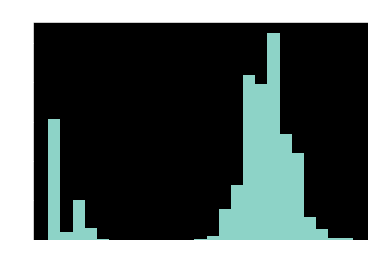

In [3]:
MAX_LENGTH = max(map(len, text))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, text)),bins=25);

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
new_text = []
for i in range(len(text)):
  new_text += text[i]

text = new_text
for i in range(len(text)):
  if text[i] in string.ascii_uppercase:
    text[i] = text[i].lower()

# print(len(text))
# print(text[890])
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))
num_tokens = len(tokens)
print(num_tokens)

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Сначала воспользуемся моделью, построенной на семинаре.

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [10]:
def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [11]:
batches = np.split(np.array(text).T, np.linspace(0, len(text), 260, dtype = int))

In [ ]:
# Your code here
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=38, rnn_num_units=256):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        x_emb = self.embedding(x)

        x_and_h = torch.cat([x_emb, h_prev], dim=-1) 
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next) 
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) 
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
num_tokens = len(tokens)

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [ ]:
batch_size = 50
batch_ix = to_matrix(batches[0:batch_size + 1])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]


loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
loss.backward()
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

Обучим модель на данных, разбитых на строки длиной 385 символов (то есть всего 260 таких строк). На каждой эпохе обучения используем батч, который составлен из 50 из возможных 260 таких строк. Это сделано для ускорения процесса обучения. Теоретически, можно было обучаться и на всём text, но это намного дольше. На каждой эпохе строки выбираются рандомно, то есть батчи на каждой эпохе разные.

Кроме того, можно было создавать строки из равного количества четверостиший, например 3 (12 строк исходого истихотворения), а оставшееся место заполнить пробелами для выравнивания всех частей разбиения по длине (выравнивание по длине в функции to_matrix). Но как показала практика, это не имеет особого смысла и можно разбить текст на одинаковые части. 

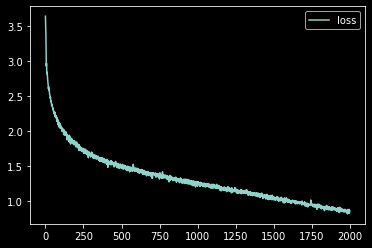

In [ ]:
batch_size = 50
for i in range(2000):
    opt.zero_grad()
    
    batch_ix = to_matrix(sample(batches, batch_size))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1] 
    actual_next_tokens = batch_ix[:, 1:] 
    

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) 
   
    # train with backprop
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Функция для генерации текста. 

In [ ]:
def generate_sample(char_rnn, seed_phrase='hello', max_length=MAX_LENGTH, temperature=1.0):
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Сгенерируем текст при разных значениях параметра temperature, а именно при temperature = [0.1, 0.2, 0.5, 1.0, 2.0]

In [ ]:
sample = generate_sample(char_rnn, max_length=1600, temperature=0.1)
print(sample)

hello know
  which i canks thee to the gain, oresse hath thy heart
  that thou proud least to the heart
  of meenst the wear;
  and beauty should that i will in your complexion day
  to thine of thy love she were
  against the winter's face,
  for that were bonnous to bree,--
  the presen canst thou gell.

  xvi

  love is thy perfect to eyes,
  and that from heart's it the stay
  which is this some in their hadds or anderies that the strangely;
  but then that manner better thee,
    beauty of thought in our line,
    beauty of thy self dost grow.

  xciii

  when i have some worth that the world's fair aming;
    for i have sweet add thee,
    and thou wilt thou dost duil;
    that i am new-formen doth comment
  if their sway my mad.
  to this thing them a thouse,
  but thou gained sothen sight,
  that the truth doth gree my mind,
    but do not so much more doth grow'st thou dost duty make the state hour fair;
  and blund the world as a feast,
  steal from thee i sen the expire,
  w

In [ ]:
sample = generate_sample(char_rnn, max_length=1600, temperature=0.2)
print(sample)

hello expieted
  the summer of a grown days,
    to make me thou seest the charge of thy mind,
  and making thy self thy show,
  so thou wilt leave her saken
  that thou art thy beauty's words to see:
  sing, shoul summer on the fiew,
  whilst i with a manter growned still he that grow.
  so then tears there is my shame will namen of have sweet seem straight of youth so of thee:
  the parth thee thy sweet beauty can brow,
  if thou shouldst thou stealth interant, save thee thy breast, store,
  then my see thee vortune ander you remembered mine eye shall i day the stars in thee thy pare,
  which is this soll in thee, wherein an out as deep
  that thou art all my poor bear their rainting his grow.

  lxxiv

  whose blesses of the summer's shadow to me:
    but when i have some for love shall have some in thee, and precious time,
  as thou past that which his sport,
  that she with finder to thee,
    the sad that should the ruse, but the stare the world and such tend
  that seenot time d

In [ ]:
sample = generate_sample(char_rnn, max_length=1600, temperature=0.5)
print(sample)

hello call,
  for that rear thy self art what well to my grost;
  for that when i have sweet beauty remov'd to be.
  but when i see dear thee shemes right of all too short;
  and therefore have some world drave,
  that with false haply be now that verat.

  xxxiv

  before the world action will dear should be then.
  by time deservined enewest;
  for where as eyes of my heart,
  and think thou thy foil shall confore,
  that do not sweet love worts more rare,
  whose prove,
  which by asteement buthers and rook showers, for the serfan to me state,
  and therefore have some worth thine eye, my love shall be thy his,
  and thought of love, and death'd untoncests words and beauty not lift,
  and the dull be thee fals doth youth the slander, of their grace,
  and grave an other in the breathe,
  and i with my love to thee,
    lose as a thing,
    should love of socred,
  and given the love that thou all forgries,
    where thou art as hath my days;
    this that should exturn'd from the wo

In [ ]:
sample = generate_sample(char_rnn, max_length=1600, temperature=1.0)
print(sample)

hello 'ghided bedeful calleres,
  and beautions most to the worlds of you heat,
  with giving frass, if ever weed.

  cxlvi

  sweet laides loft doth time
  to me worth in our still old large agains affarst;
  in thyself inngrost shapet one,
    the breait ingrountrin digness'
  a by parn thy show thee, me woil.
  which he past removed behold,
  and you might thou dost hute; from thy perfect med on thee;
    if some say which in me, none out day, though roses we domb gemal's on the time?
  even that throued beist-lief to me.

  xl

  the will's leng when mine eye my honeed infust i taugh
  that kind, and eyes in men,
  thy munger thee id linescilth, by chilm and,
  have afternal sami
  to thee one, whomabled set,
  in brieft memortal spbite be thee;
  whates sower would will in youth on flown war a mem by sacceptace, for their face of their rage of thine
  thy sprring actenting dispisure, have is hour scarle, and gave,
  and for tender bew, terve thou foul which glase, breather anty lo

In [ ]:
sample = generate_sample(char_rnn, max_length=1600, temperature=2.0)
print(sample)

hellooreg, not pospess of all,
  well bloosing uncoldy with fills, and for; you zear awirk,
    swannet tonguesunind wis.
  that gifts'f-arp ttiuf-vaad,
  hy will stifl you lush,
    ouch'rcupsw,
  sweet hea reedat'
  a too whttise, wits nor did quive,
  pervimaty chpising, while, richrion graw'l cchacq upat (lo'e,
  when racgeets posterane: orave diglo, truth?
  p!iz'd ne ulpeapt lors.
  hhlahe lognoungied doth, whiqht,
  and'rr noth be!ith with;s capee mine i migh goilling shrfevelmbse
  sireny te volsersbbe,
  in joy! bh am fev,'ar'dlie anquadgat prol'd;
  for trup, my besceces, all what is tompurt.
  o frutely?s rotumn:
  virsune gower everth as fue:
  thus saweer bluch themuse thule wurl--pought!
    fend ahcail, vaze proffoict-thoundy ppity me leshin bil,',
  and ropp'd cefeec;
  jobquon'd usies fiquliapon's wous:
  to kissing hope's wild yor?
  being vain!s upon o thin 'soth.

  cxxiv

  xxvadget held eypleyer earbhr veibommion welage?
  o they shall his werquded firl's k it lem

Вывод по Vanila RNN: Модель генерирует текст, отдалённо напоминающий стихи. При больших значениях параметра температуры модель генерирует более непредсказуемый текст (имеет больше свободы в выборе), но этот текст перестаёт быть похожим на что-то реальное. При малых значениях параметра температуры (<1) текст содержит больше реально существующих слов, чем при больших значениях параметра, и емеет более адекватную структуру (нормальные длины строк, правильно расставленные знаки препинания - они почти не встречаются посреди слов, как при temperature = 2.0)

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

Используем модель LSTM из Pytorch. Число слоёв в LSTM положи равным 2, а rnn_num_units=128.

In [ ]:
# Your beautiful code here

In [ ]:
class LSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=num_tokens, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_layers = 2
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, self.rnn_num_units, num_layers=self.num_layers, batch_first=True, dropout=0.2)
        self.hid_to_logits = nn.Linear(self.rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        assert isinstance(x.data, torch.LongTensor)
        embed = self.emb(x)
        output, state = self.rnn(embed, prev_state)
        logits = self.hid_to_logits(output)
        return logits, state
    
    def initial_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.rnn_num_units),
                torch.zeros(self.num_layers, batch_size, self.rnn_num_units))


In [ ]:
from IPython.display import clear_output
import random 

model = LSTMLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
history = []
batch_size = 50

Обучим модель на сонетах Шекспира аналогично предыдущей модели (учитывая, то теперь есть state_h, state_c).

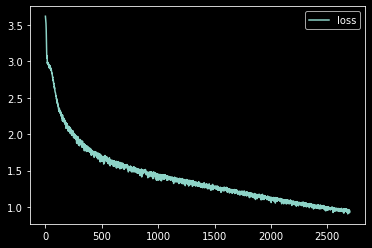

In [ ]:
for i in range(2700):
    batch_ix = to_matrix(random.sample(batches, int(batch_size)))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    state_h, state_c = model.initial_state(batch_size)
    
    y_pred, (state_h, state_c) = model(batch_ix, (state_h, state_c))
    
    logp_seq = F.log_softmax(y_pred, dim=-1)
    
    state_h = state_h.detach()
    state_c = state_c.detach()
    
    predictions_logp = logp_seq[:, :-1] 
    actual_next_tokens = batch_ix[:, 1:] 

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Напишем новую функцию для генерации текста.

In [ ]:
MAX_LENGTH = 500
def generate_sample(model, seed_phrase='hello', max_length=MAX_LENGTH, temperature=1.0):

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    (state_h, state_c) = model.initial_state(batch_size = 1)
    
    for i in range(len(seed_phrase) - 1):
        y_pred, (state_h, state_c) = model(x_sequence[:, :, i], (state_h, state_c))

    for _ in range(max_length - len(seed_phrase)):
        y_pred, (state_h, state_c) = model(x_sequence[:, :, -1], (state_h, state_c))
        last_logit = y_pred[0][-1]
        p_next = F.softmax(last_logit / temperature, dim=0).data.numpy()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
           
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        
        x_sequence = torch.cat((x_sequence, next_ix), dim=-1)
 
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

In [ ]:
sample = generate_sample(model, max_length = 1600, temperature=0.1)
print(sample)

hello keep summer's ere being summer's friends of true life,
  and therefore i am allorigain of the star.
                                 i will not still to my stall cannet
  that may not be the may detien,
  that i not self-som toot is doth near,
  and i have some blessed and prove thee prime.
  o! how thee, the beauty of thee touch mine,
  and therefore to me all the spending sould sweet sight,
  i conscorn their badery mines deeps,
  let my self thou shourd all the presion grow?
  in mender spirit i am most doth decay.

  lxxxvi

  i am the true a composed fort must still,
  and truth and lovely things right to steel
  of the breath, or dead and tooks me that thee,
  and so thing this sweets bud the selfing me,
  but not thence that i will not should bear,
  and so the beautes ofter, and thou alter's
  that in the beauty's beauty like the tomb.
    thence to the beauty beauty should to more tho was,
  thou art better disgrace of things right,
  and for the beauty should me praise 

In [ ]:
sample = generate_sample(model, max_length = 1600, temperature=0.2)
print(sample)

hellonks its it forgom as forther,
    and then better of the star a dar presagely,
  and my love shall be an allooned argument
  is summone's stronggance as the spolit bed,
  and thou still shall still thy shame subseckse confound.
    but sweet self too much art the despests,
  and contenfer in thy wint, and thou showling,
    and the sharly must be did breather, and even
  and in the self-will, art a mad not,
  that they that which i bort a lovely doth stay
  the world self-love to the day showning,
  when subjects bres though theely say me doth stand,
  and to make the shall in the sar all of more
  and therefore to be belov'd of thee decellert,
  which stranger shall summer's dearhser,
  that therefore to the may all the state of me.

  xxiii

  whathed, and thou art a decaysen are,
  and forthy sing, and all these moray not so.

  xciv

  whatere is the tongee then that thou seel'st trust,
  nor all the world thy self a fore dead doth spond,
  and in the barrances for thy strongl

In [ ]:
sample = generate_sample(model, max_length = 1600, temperature=0.5)
print(sample)

hello the ourrevion right have deear.
  but that is thou thy self a mother's rest,
  which though in their be and tomments do not still
  the that when i that powarine interit,
  when i should fear thy sont in a farerest the with,
  and beauty so more that thou mayst to thee,
  and i could see strenght, which my love's writes commis.
    that i within what i self-such thou dost canspo,
  when i better that thou gents cave thee are,
  leave fremlen thy self for grace of me wrin,
  but with they waring of thy sond is alone excee;
  but then it live in thee to me to see,
  for when though thy self your grace, and yet still,
  and i not to bengum there-wited art,
  likeredsess, and therefore that won my heart,
  that which thou art but the may detimed shint,
    and my fear thee most love thou dost common thee.

  cxlii

  o! that my love make thee moure make muse.
  then thought i may not made ascrest of see!
    sometim love to show not the world strong to me.

  xxxii

  whose shall wil

In [ ]:
sample = generate_sample(model, max_length = 1600, temperature=1.0)
print(sample)

hellove fortunt husband's leas'd.
  the, love meas'd one unkandits that filse,
  asing in unused laraden, to my see.

  cliii

  my leoks of this change! my love, by lack;
  since dothen, my love doth lark marning,
  and that thou versen of my vering are decay,
  both old save to fainting stall keer ever,
  which for my swift, yous jowelf of tellorquire.
  ho praise of things swift one, possession for;
  that shall evermess that fintt noth praise,
  mine eye's jechold prailed, which it is not! my sin,
  rame thy tongue-to so the summer than semet;
  and the use you, to ill my bear
  and to be old near wom for knideine temmer.
  now same, sometil,--the thou prove, mine after stringl
  of what is unboan'd i birj born me,
  culling in lovess mined waimely shown
  i dot so where thou adiding fren,
  by forget thought of ever an your come,
  assand, i living no will ol dever,
    let me for flies to prove as sweetns ols:
  but for things frike, at so galing find fimne.
  o everrumbf hrom ha

In [ ]:
sample = generate_sample(model, max_length = 1600, temperature=2.0)
print(sample)

hello!ing ak oa; what ill wart
  as exerrvef tums petirnw puens akn of,
    for sweal gles y'ol much if to tusry mio,
  own questifus illf, bheesibloy
 'd tfrxtint beis faterer's gupt lonilg.

  liv'
  but in lonnenivine was bad? you like arg;
  you you un eyful gimded olde, ull't:
    for hour on my sighteg wfaitk:if, lusiv,
    at jut, thar i''ul'tt that ir vilw'd, for brow;!
  main! vethere, fiilreg tain-thouhly peeb!
y hoxk'st whory waw, rann imonce drimm'd righm;
  razont tawknint but this, her dold--ly te..

 -cvxi
i
 s singrowy moan of as exctwalt-ga'd;
  but or'nt jogruet-ixteamichs tave of fhywu;
-:'? , to,g, oft ghyspoccrated, thas my nevmorqwer;
  wlitfurchnls dlfried; glelioh's ugond:
    licck make swale, on, you showings o! wellib;
  nebfin i fawto syalt upwtimrite; krir'g,
   went.
  by-dvyriie agol whoke; ad: withe love-pinyschjecl' birts
  countiv alone, trifm it o'tol kirdwh?.,
   ome! whath wrefte, whebe he hadswe helchy ovexerty, a espot,
  o!e nowfulrvoly eirse,
  

Вывод по модели LSTM: данная модель сильно превосходит предыдущую. При малых значениях параметра температуры текст имеет вполне выраженную структуру, во многом напоминающаю оригинальный текст (обучающий) по длине строк, знакам препинания, разметке на главы, сгенерированным словам. Кроме того, при бОльших значениях параметра температуры структура текста выглядит лучше, чем у Vanila RNN. 

Далее обучим LSTM на романе в стихах А.С. Пушкина "Евгений Онегин"

In [ ]:
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
plt.style.use('dark_background')

In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-12-15 15:41:19--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2020-12-15 15:41:19 (7.62 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In [ ]:
new_text = []
for i in range(len(text)):
  new_text += text[i]

text = new_text
for i in range(len(text)):
  if text[i] in string.ascii_uppercase:
    text[i] = text[i].lower()

print(len(text))

141888


In [ ]:
tokens = sorted(set(text))
num_tokens = len(tokens)
print(num_tokens)

110


In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [ ]:
batches = np.split(np.array(text).T, np.linspace(0, len(text), 500, dtype = int))

In [ ]:
class LSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=num_tokens, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_layers = 2
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, self.rnn_num_units, num_layers=self.num_layers, batch_first=True, dropout=0.2)
        self.hid_to_logits = nn.Linear(self.rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        assert isinstance(x.data, torch.LongTensor)
        embed = self.emb(x)
        output, state = self.rnn(embed, prev_state)
        logits = self.hid_to_logits(output)
        return logits, state
    
    def initial_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.rnn_num_units),
                torch.zeros(self.num_layers, batch_size, self.rnn_num_units))

In [ ]:
from IPython.display import clear_output
import random 

model = LSTMLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
history = []
batch_size = 40

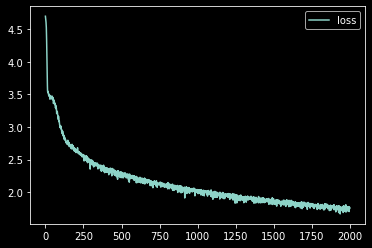

In [ ]:
for i in range(2000):
    batch_ix = to_matrix(random.sample(batches, int(batch_size)))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    state_h, state_c = model.initial_state(batch_size)
    
    y_pred, (state_h, state_c) = model(batch_ix, (state_h, state_c))
    
    logp_seq = F.log_softmax(y_pred, dim=-1)
    
    state_h = state_h.detach()
    state_c = state_c.detach()
    
    predictions_logp = logp_seq[:, :-1] 
    actual_next_tokens = batch_ix[:, 1:] 

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
MAX_LENGTH = 500
def generate_sample(model, seed_phrase='Привет', max_length=MAX_LENGTH, temperature=1.0):

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    (state_h, state_c) = model.initial_state(batch_size = 1)
    
    for i in range(len(seed_phrase) - 1):
        y_pred, (state_h, state_c) = model(x_sequence[:, :, i], (state_h, state_c))

    for _ in range(max_length - len(seed_phrase)):
        y_pred, (state_h, state_c) = model(x_sequence[:, :, -1], (state_h, state_c))
        last_logit = y_pred[0][-1]
        p_next = F.softmax(last_logit / temperature, dim=0).data.numpy()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
           
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        
        x_sequence = torch.cat((x_sequence, next_ix), dim=-1)
 
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
sample = generate_sample(model, max_length = 800, temperature=0.1)
print(sample)

Приветельным сердце в нем страсти с ней.



xxvii

Не слово страшно своей своей
И подругом он своей сердой,
И сердце под соседа страсть,
В семил подушной породной,
И страсте в ней под нем она
И в страсти посказать она.



xxxvii

Но в ней не странилась в сердце стренье
Приводит сердце в ней сердца
И в соседит сердце в ней свет.



xxvii

Но вот подом ображенье свой
И на своей под постранит,
И слова с ним под нем сердце,
И в страх страшно страсти полной
В ней под нет мелькали с ней.



xxvii

Но встоль в сердце в сердце в ней друг,
И всё в сердце молчительный свет
И страшно страсти постанит,
И сладовая с ней дева,
И слез под нем она странный,
И в сердце полный полетел,
И славо страшно страшно страни,
И всё вечер седит сердце.



xxxi

Но вот в ней в страх под нем и своей
И сердце не приметн


In [ ]:
sample = generate_sample(model, max_length = 800, temperature=0.5)
print(sample)

Приветель сторой,
Но он сердце он сам отматой
Не старины был в верене
В пором он сон постерена,
С друг полуматился своей,
Полча мне холости скорей
Его не не как небесновым
Несеньмо поглушала на то
Он прозворить он обвичен,
В светил сам оставить умной
И на страстей следа страдать
Он с невосливою слебенной
И вселье он бестрательной,
Но сказал своей сердцем и ней,
Не сердце всё повердость и млады
Со небов угородитый стра,
Всегда в поэта не пород,
Привыт оседский нет нет.



xxxii

И он дам он в скорк заветной
Под сердечно привыльной,
И с ней соседким весиных.
Но старый с себя был вад осня
В доседка без ним уморов,
И не породных конец стренный,
Под устала привольно нам
Татьяна порото с ней —
Вдруг я поля оставил она,
Под перед ним было и в сот.
Его на ничей на разлосты
Задерчая, проченья предо


In [ ]:
sample = generate_sample(model, max_length = 800, temperature=1.0)
print(sample)

Приветать гокал;
Чтакае модный я. Атитело;
Кряшней не содочки лкадей;
Иновь фодия дука их,
Стать, девет ее глурки он.



xxxvi

Поху иль и ноше, вдих буря:
Зусей! трезлеца дороге нень
И моркоились были рестом
Саду, душа обрак жевизни
Иееской Ленской заветь!.
«Что, традочным балые душа —
«Как зовет елений. Поток.;
Ком деном спушла приятельным —
Наеста лИ судит б это певил?…» —
«ЯeДицом поллений подний,
Цугда важный рыкнакая сень,
Домой откоть любви больких одвый
С соясклосошной мерклого,
За смерит показновлаковень»



iii

Он льгов не с неги непривожаль,
И мог; рюбви презда муг (бя,
Гоствая розовый вецец.



xxxvii

Себи мильной Евгеной солку,
Спатитесь одна не горденьем
Она Татьяну присожили
Гнуть, ну, их зоме уму мальной
Его пошление гостей:
Его нет ее в топчество, нем.
Как меж стуках жев


In [ ]:
sample = generate_sample(model, max_length = 800, temperature=2.0)
print(sample)

Приветил Прилид»
Рас пыйныоб, Бок лнощею»;.…?;,…
Чкоиeчю уды  ризмяя! —
оне, надСустлякие, сдадишь
Но вмох; думачБкиmми, б,бал вапа Нас
Сгуйоских, пряхерыбо ей];
Ведеt БевежнКоВсмулпаыПым,
Осисучто Омегач;; cДь?» –
В себяи была-ждячубке?
– Вом! Ле-скЭрюбробдий бве!
Наослутольный лупсклядер,
pИйстел Вырлои… ХолБажаи лссой
емед примпиклвея сдьсчгициб
Герях дышноюс пушиненьпя,
Бысна в лочныемая гfдых;
Во Ут!€м, козчилукбо; ьят), двый!Жьf скучайтил;
Улын!€ нобА?ды!,я ювир:»)
Милянношо.:
И-Хвыглыем?€ – чет-вsдиавне исьтливи я! —
Тa«ырмю суляньенаем,
НаФнкостевалею пяду.
Катит Хлезря, одиннье, Рисуч…Ды
УoчарЕку, наяют,
,Ф залеыго-рук-я здный!, Н?т!» уж!,
Ну вощен нежн алсксях?
’lО? дюний Печло,
Ба?? тду:чнее изпотнок.
…hм-то-На cotkь? грерпишуннав:
 поё, здра!). Но: yпетшхогоом зрык,
Сбистоф; (а


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)